In [16]:
from dasi import LibraryDesign, Design
from pyblast.utils import make_linear, make_circular, load_fasta_glob, load_genbank_glob
import warnings
from Bio import BiopythonParserWarning
from matplotlib import MatplotlibDeprecationWarning
from dasi.constants import Constants

warnings.simplefilter("ignore", BiopythonParserWarning)
warnings.simplefilter('ignore', MatplotlibDeprecationWarning)

templates = make_circular(load_genbank_glob("../tests/data/test_data/genbank/templates/*.gb"))
registry = make_circular(load_genbank_glob("../tests/data/test_data/genbank/benchling_registry/*.gb"))
primers = make_linear(load_fasta_glob('../tests/data/test_data/primers/primers.fasta'))
queries = make_circular(load_genbank_glob('../tests/data/test_data/genbank/designs/*.gb'))

assert templates
assert registry
assert primers
assert queries

design = Design(span_cost)
design.add_templates(registry)
design.add_primers(primers)
design.add_queries(queries)
design.add_fragments([])

# blast = design.blast_factory('queries', 'queries')
# blast.quick_blastn()
# results = blast.get_perfect()
# results = [r for r in results if r['subject']['origin_key'] != r['query']['origin_key']]

# design.container_factory.seqdb.update(blast.seq_db.records)
# design.container_factory.load_blast_json(results, Constants.SHARED_FRAGMENT)
design.compile()

In [81]:
"""
less than 25% GC content
higher than 75% GC content
homopolymeric runs of 10 or more A/Ts
homopolymeric runs of 6 or more G/Cs
repeats greater than 14bp
hairpins

GC scew?
windowed scew?
"""
import random
import re


def random_seq(length, bases=None):
    if bases is None:
      bases = "AGTC"

    seq = ""
    for _ in range(length):
        i = random.randint(0, len(bases)-1)
        seq += bases[i]
    return seq

HOMOPOLYMERIC_AT = 6
HOMOPOLYMERIC_GC = 10
REPEAT_MAX_LENGTH = 14
PARTITION_OVERLAP = 25

def get_AT_complexity(seq):
  complexities = []
  for match in re.findall("[AT]+", seq, re.IGNORECASE):
    if len(match) > HOMOPOLYMERIC_AT:
      complexities.append(len(match) - HOMOPOLYMERIC_AT + 1)
  if complexities:
    return max(complexities)
  return 0

def get_GC_complexity(seq):
  complexities = []
  for match in re.findall("[GC]+", seq, re.IGNORECASE):
    if len(match) > HOMOPOLYMERIC_GC:
      complexities.append(len(match) - HOMOPOLYMERIC_GC + 1)
  if complexities:
    return max(complexities)
  return 0

def get_GC_content(seq):
  s = seq.upper()
  return (s.count('G') + s.count('C')) / len(s)

def get_GC_content_complexity(seq):
  gc = get_GC_content(seq)
  return abs(gc * 100. - 50) * 17 / 25.

def iter_kmers(seq, length):
  for i in range(0, len(seq)-length):
    yield (i, seq[i:i+length])

def count_kmers(seq, length):
  kmers = {}
  for kmer in iter_kmers(seq, length):
    kmers.setdefault(kmer[1], list())
    kmers[kmer[1]].append(kmer[0])
  return kmers

def get_repeat_complexity(seq, length):
  repeats = {
      
  }
  for kmer, positions in count_kmers(seq, length).items():
    if len(positions) > 1:
      these_kmers = [kmer] * len(positions)
      kmer1 = kmer2 = kmer
      l = len(kmer)
      while kmer1 == kmer2:
        l += 1
        kmer1 = seq[positions[0]:positions[0]+l]
        kmer2 = seq[positions[1]:positions[1]+l]
      passes = True
      if len(kmer1) >= length:
        for k in repeats:
          if kmer1 in k:
            passes = False
            break
        if passes:
          repeats[kmer1] = (len(kmer1) - length) * 2
  return repeats

def complexity(seq):
  complexity_info = {}
  complexity_info['Homopolymeric AT'] = get_AT_complexity(seq)
  complexity_info['Homopolymeric GC'] = get_GC_complexity(seq)
  complexity_info['High GC Content'] = get_GC_content_complexity(seq)
  complexity_info['Repeats'] = get_repeat_complexity(seq, REPEAT_MAX_LENGTH)
  return complexity_info

def complexity_score(seq):
  data = complexity(seq)
  total = 0
  for k, v in data.items():
    if isinstance(v, int) or isinstance(v, float):
      total += v
    else:
      for _v in v.values():
        total += _v
  return total

In [87]:
from itertools import tee
import bisect

def group_by(a, key, valfunc=None):
  groups = {}
  for x in tee(a)[0]:
    k = key(x)
    groups.setdefault(k, list())
    if valfunc:
      x = valfunc(x)
    groups[k].append(x)
  return groups
seq = random_seq(1000)

matches = []
for m in re.finditer('[AT]{6,}', seq):
  matches.append((m.start(), m.end(), m.group()))

a = sorted(matches, key=lambda m: m[0])
b = sorted(matches, key=lambda m: m[1])

bisect.bisect_left(a, )

In [107]:
class SequenceStats(object):
    
    def __init__(self, seq):
        self.seq = seq
    
        self.at_matches = []
        a_keys = [_a[0] for _a in a]
        for m in re.finditer('[AT]{6,}', seq):
            matches.append((m.start(), m.end(), m.group()))
        self.at_a = sorted(matches, key=lambda m: m[0])
        self.at_b = sorted(matches, key=lambda m: m[1])

100%|██████████| 8130/8130 [00:00<00:00, 203102.50it/s]


0


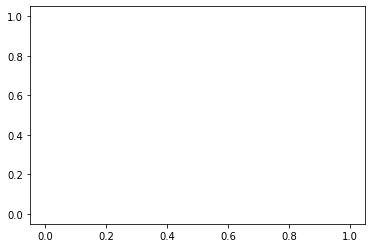

In [106]:
from tqdm import tqdm
import numpy as np
import bisect

nseqs = 0
scores = []
for qk, g in design.graphs.items():
    seq = str(design.seqdb[qk].seq)
    
    matches = []
    for m in re.finditer('[AT]{6,}', seq):
        matches.append((m.start(), m.end(), m.group()))

    a = sorted(matches, key=lambda m: m[0])
    b = sorted(matches, key=lambda m: m[1])
    
    a_keys = [_a[0] for _a in a]
    b_keys = [_b[1] for _b in b]
    print(a_keys)
    print(b)
    for n1, n2, edata in tqdm(g.edges(data=True), total=g.number_of_edges()):
        if n1.type == 'B' and n2.type == 'A':
            nseqs += 1
            seqslice = seq[n1.index:n2.index]
            if len(seqslice):
                np.unique(seqslice, return_counts=True)
                i = bisect.bisect_left(keys, n1.index)
                
print(len(scores))

import pylab as plt
%matplotlib inline

plt.plot(scores)

In [89]:
n1

AssemblyNode(index=326, expandable=True, type='B', overhang=False)

In [75]:
import seaborn as sns
print(len(scores))
len([s for s in scores if s > 10])

10399


6832

In [69]:
sns.distplot?

In [22]:
list(g.edges())[0]

(AssemblyNode(index=0, expandable=True, type='A', overhang=True),
 AssemblyNode(index=4779, expandable=True, type='B', overhang=True))

In [ ]:
from dasi.models import AlignmentContainer
from dasi.utils import sort_with_keys
from dasi.utils import Region

def overlapping_groups(group_list_a, group_list_b):
    group_sort, group_keys = sort_with_keys(
            group_list_b, key=lambda x: x.query_region.a
        )
    tuples = []
    for group_a in group_list_a:
        alignments = []
        overlapping = AlignmentContainer.filter_alignments_by_span(
                group_sort,
                group_a.query_region,
                key=lambda p: p.query_region.a,
                end_inclusive=False,
            )
        if group_a in overlapping:
            overlapping.remove(group_a)
        tuples.append((group_a, overlapping))
    return tuples


all_groups = []
for container in design.container_factory.containers().values():
    all_groups += container.get_groups_by_types(Constants.SHARED_FRAGMENT)
    
grouped_by_qk = {}
for g in all_groups:
    grouped_by_qk.setdefault(g.query_key, list())
    grouped_by_qk[g.query_key].append(g)

for qk, groups in list(grouped_by_qk.items())[:]:
    overlapping = overlapping_groups(groups, groups)
    starts = []
    ends = []
    for g, glist in overlapping:
        starts.append(g.query_region.start)
        ends.append(g.query_region.end)
        for _g in glist:
            starts.append(_g.query_region.start)
            ends.append(_g.query_region.end)
#     overlapping = overlapping_groups(groups, groups)
#     print(len(overlapping))

In [ ]:
from copy import deepcopy

def to_undirected(graph):
    """.to_undirected is implemented in networkx out of the box, however, it
    suffers from occational infinite recursion errors during the deepcopy phase
    of the method (unknown as to why)."""
    undirected = nx.Graph()
    copied = deepcopy(graph)
    for n in copied.nodes:
        ndata = copied.nodes[n]
        undirected.add_node(n, **ndata)
    for n1, n2 in copied.edges:
        edata = copied.edges[n1, n2]
        undirected.add_edge(n1, n2, **edata)
    return undirected

def get_subgraphs(graph):
    """Get independent subgraphs."""
    node_list = list(graph.nodes)
    subgraphs = []
    while len(node_list) > 0:
        node = node_list[-1]
        subgraph = nx.bfs_tree(to_undirected(graph), node)
        for n in subgraph.nodes:
            node_list.remove(n)
        subgraphs.append(graph.subgraph(subgraph.nodes))
    return subgraphs


interaction_graph = nx.Graph()

for g in all_groups:
    for a in g.alignments:
        n1 = (a.query_key, a.query_region.a, a.query_region.b)
        n2 = (a.subject_key, a.subject_region.a, a.subject_region.b)
        interaction_graph.add_edge(n1, n2, alignment=a)
graphs = sorted(get_subgraphs(interaction_graph), key=lambda x: x.number_of_nodes())

graph = graphs[-2]

def has_repeats(g):
    """Check if the interaction graph has a repeated DNA sequence"""
    grouped_by_key = {}
    for n in g.nodes:
        grouped_by_key.setdefault(n[0], list())
        grouped_by_key[n[0]].append((n[1], n[2]))
    for k, v in grouped_by_key.items():
        if len(v) > 1:
            print(grouped_by_key)
            return True
    return False
        
nx.draw(graph, node_size=25)

# clusters have 
clusters = []

for g in graphs:
    if not has_repeats(g):
        alignments = []
        for n1, n2, edata in g.edges(data=True):
            alignments.append(edata['alignment'])
        clusters.append(alignments)

qk_to_cluster_indices = {}
for i, c in enumerate(clusters):
    for alignment in c:
        qk_to_cluster_indices.setdefault(alignment.query_key, (alignment, list()))
        qk_to_cluster_indices[alignment.query_key][1].append(i)

for qk, container in design.container_factory.containers().items():
    alignment, cluster = qk_to_cluster_indices[qk]
#     graph = design.graphs[qk]
#     container.filter_alignments_by_span

In [ ]:
design.compile()

In [ ]:
design.graphs

In [ ]:
design.seqdb['2bf55dde-2d75-4e56-b6ce-eb09479d461e'][734:811]

In [ ]:
all_keys = dict()
for g in all_groups:
    keys = [g.query_key] + g.subject_keys
    keys.sort()
    gkey = tuple(keys)
    all_keys.setdefault(gkey, list())
    all_keys[gkey].append(g)
    
print(len(all_groups))
print(len(all_keys))

all_keys

In [ ]:
import networkx as nx
%matplotlib inline

blast = design.blast_factory('queries', 'queries')

blast.quick_blastn()
results = blast.get_perfect()
results = [r for r in results if r['subject']['origin_key'] != r['query']['origin_key']]

g = nx.MultiGraph()

edges = []
for r in results:
    sk = r['subject']['origin_key']
    qk = r['query']['origin_key']
    k1 = (qk, (r['query']['start'], r['query']['end']))
    k2 = (sk, (r['subject']['start'], r['subject']['end']))
    keys = sorted([k1, k2])
    edges.append(keys)
    
for n1, n2 in edges:
    g.add_edge(n1[0], n2[0])
    
nx.draw(g)

In [ ]:
r